# DICOM File Image Parser
Dicom_image class is used for reading and managing DICOM x-ray image file.


In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [2]:
import cv2
import imgaug as ia
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage
from imgaug import augmenters as iaa
from matplotlib import colors
import random
import pydicom as dicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
from os.path import join, exists

## Define class: Dicom_image

In [3]:
class Dicom_image:
    def __init__(self, path, image_name, classes=[]):
        '''
        Import image
        :param path: Path to the image
        :param image_name: image name
        '''
        self.path = path
        if image_name.endswith('.dicom'):
            self.file_name = image_name
            self.image_name = image_name[:-6]
        else:
            self.file_name = image_name + '.dicom'
            self.image_name = image_name
        self.file_path = join(self.path, self.file_name)
        if exists(self.file_path):
            self.dicom_file = dicom.dcmread(self.file_path)
            self.image_orig = self.read_xray()
            self.orig_size = (self.image_orig.shape[0],self.image_orig.shape[1]) # Original image size before resizing - (h,w)
            self.bbs = [] # Initial bounding boxes
            self.classes = classes
            self.image_aug = None # Augmented image
            self.bbs_aug = []  # bounding boxes after augmentation
            self.image_resize = None # image after resize
            self.bbs_resize= [] # bounding boxes after resize
        else:
            print (f"Error! {self.file_path} does not exists!")
    
    def read_xray(self, voi_lut = True, fix_monochrome = True):
        '''
        Read image data from the dicom file
        (reference: https://www.kaggle.com/raddar/vinbigdata-competition-jpg-data-2x-downsampled)
        '''
        data_file = self.dicom_file
        # VOI LUT (if available by DICOM device) is used to transform raw DICOM data to "human-friendly" view
        if voi_lut:
            data = apply_voi_lut(data_file.pixel_array, data_file)
        else:
            data = data_file.pixel_array

        # depending on this value, X-ray may look inverted - fix that:
        if fix_monochrome and data_file.PhotometricInterpretation == "MONOCHROME1":
            data = np.amax(data) - data
        data = data - np.min(data)
        data = data / np.max(data)
        data = (data * 255.0).astype(np.uint8)
        # Use CLAHE (Contrast Limited Adaptive Histogram Equalization) to improve contrast
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        data = clahe.apply(data)
        data = cv2.cvtColor(data,cv2.COLOR_GRAY2RGB) # convert to 3 channel grayscale
        return data

    def add_bbox(self, xmin, ymin, xmax, ymax, cl_label):
        '''
        Add a bounding box to list of bounding boxes in the image
        :param xmin, ymin, xmax, ymax: bounding box coordinates
        :param cl_label: string label class of the bounding box
        '''
        self.bbs.append(BoundingBox(x1=xmin, y1=ymin, x2=xmax, y2=ymax, label=cl_label))
    
    def add_bbox_from_df(self, df):
        '''
        Add bounding boxes to the list of bounding boxes from a pandas dataframe
        :param df: dataframe that contains bounding boxes and image_id with the same self.image_name
        '''
        image_df = df[df['image_id']==self.image_name]
        for i, row in image_df.iterrows():
            self.add_bbox(row.x_min, row.y_min ,row.x_max, row.y_max,str(row.class_id))
    
    def remove_bbox(self, bbox):
        '''
        Remove a bounding box from the list of bounding boxes
        :param bbox: a list of bbox coordinates and label in the form [xmin, ymin, xmax, ymax, cl_label]
        '''
        if bbox in self.bbs:
            self.bbs.remove(bbox)
            success = True
        else:
            success = False
        return success
    
    def clear_bbs(self):
        '''
        Remove all bounding boxes from the list of bounding boxes
        '''
        self.bbs = []
    
    def minmax_bbox(self, bbs=None):
        '''
        Find min and max values of bounding boxes (so cropping will not cut the bboxes)
        :param bboxs (default: self.bbs): list of bounding boxes
        '''
        bbs = self.bbs if bbs is None else bbs
        bbs_xmax = max([bbs[i].x2_int for i in range(len(bbs))])
        bbs_ymax = max([bbs[i].y2_int for i in range(len(bbs))])
        bbs_xmin = min([bbs[i].x1_int for i in range(len(bbs))])
        bbs_ymin = min([bbs[i].y1_int for i in range(len(bbs))])        
        return bbs_xmin, bbs_ymin, bbs_xmax, bbs_ymax
    
    def sort_bbs(self):
        '''
        Sort the bbs list of bounding boxes by the class label
        :param none
        '''
        def sort_class(elem):
            return elem.label
        self.bbs.sort(key = sort_class)
        return self.bbs
    
    def resize (self, img=None, bounding_boxes=None, downscale_factor = 1, max_dim = None):
        '''
        Resize image
        :param downscale_factor: downscale factor (default = 1)
        :param max_dim: downscale so that largest dimension (height or width) is equal max_dim. The other dimension reduced proportionately.
        '''
        img = self.image_orig if img is None else img
        img_size = (img.shape[0], img.shape[1])
        bounding_boxes = self.bbs if bounding_boxes is None else bounding_boxes
        if type(bounding_boxes)==BoundingBoxesOnImage:
            bbs = bounding_boxes
        else:
            bbs = BoundingBoxesOnImage(bounding_boxes, shape=img.shape)
        
        if downscale_factor > 1:  # Resize by a constant factor
            new_shape = tuple([int(x / downscale_factor) for x in img_size])       
        elif max_dim != None: # Resize so that maximum length (width or height) will be max_dim. The other dimension resized proportionately
            downscale_factor =  max(img.shape) / max_dim
            new_shape = tuple([round(x / downscale_factor) for x in img_size])
        else:
            new_shape = img_size # Don't resize

        self.image_resize = ia.imresize_single_image(img, new_shape)
        self.bbs_resize = bbs.on(self.image_resize)
        return self.image_resize, self.bbs_resize
    
    def augment(self, img=None, bounding_boxes=None, keep_size=False):
        '''
        Augment the image: random brightness, scale, shear and crop
        :param img: Image to be processed
        :param bounding_boxes: Bounding boxes (default is the original image bboxes).
        :param keep_size: Keep the size of the image after cropping (default is False - don't resize to original size)
        '''
        img = self.image_orig if img is None else img
        bounding_boxes = self.bbs if bounding_boxes is None else bounding_boxes
        if type(bounding_boxes)==BoundingBoxesOnImage:
            bbs = bounding_boxes
        else:
            bbs = BoundingBoxesOnImage(bounding_boxes, shape=img.shape)
        
        # Do basic augmentation - brightness, scale and shear
        seq = iaa.Sequential([
            iaa.MultiplyBrightness((0.7, 1.2)),
            iaa.Affine(scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}),
            iaa.Affine(shear=(-10, 10))
        ])
        image_aug, bbs_aug = seq(image=img, bounding_boxes=bbs)
        
        # Do random Cropping up to 20% of all sides
        # First - find safe margins for cropping so that bboxes won't be cropped out
        if not bbs_aug.empty:
            max_percent = 0.2
            w = image_aug.shape[1]
            h = image_aug.shape[0]
            bbs_xmin, bbs_ymin, bbs_xmax, bbs_ymax = self.minmax_bbox(bbs=bbs_aug)
            marg_left = (bbs_xmin -2) / w
            marg_right = (w - bbs_xmax -2) / w
            marg_top = (bbs_ymin -2) / h
            marg_bottom = (h - bbs_ymax -2) / h
            max_crop_percent = min(0.3, marg_left, marg_right, marg_top, marg_bottom)
            max_crop_percent = 0 if max_crop_percent<0 else max_crop_percent
        crop = iaa.Crop(percent=(0, max_crop_percent), keep_size=keep_size) # crop image
        image_aug=crop.augment_image(image_aug)
        bbs_aug = bbs_aug.on(image_aug)
        
        self.image_aug, self.bbs_aug = image_aug, bbs_aug
        return image_aug, bbs_aug

    def parse_label(self, bb):
        '''
        Convert label index to label class name and color
        :param bb: bounding box with label
        '''
        color_pallete = ['lightcoral','brown','red','darksalmon','chocolate',
                  'darkorange','darkgoldenrod','gold','olive','yellow',
                  'green','lime','blue','darkorchid']
        try:
            class_code = int(bb.label)
            class_name = self.classes[class_code]
        except:
            class_code = random.randrange(len(colors)) # if class nunber was not specified, or label was not an index to class
            class_name = ''
        cl_color = tuple(np.array(colors.to_rgb(color_pallete[class_code]))*255)
        return cl_color, class_name
    
    def show_image(self, img=None, bounding_boxes=None, showbbs=True, showlabel=True):
        '''
        Show the image with bounding boxes
        :param img: image to be processed
        :param bounding_boxes: list of bounding boxes
        :param showbbs: flag to show the bounding boxes, if there are any (default=True)
        :param showlabel: flag to show the labels of the bounding boxes, if there are any (default=True)
        '''
        img = self.image_orig if img is None else img
        bounding_boxes = self.bbs if bounding_boxes is None else bounding_boxes
        bbs=[]
        if bounding_boxes != []:
            if type(bounding_boxes)==BoundingBoxesOnImage:
                bbs = bounding_boxes.bounding_boxes
            else:
                bbs = bounding_boxes
            
            for bb in bbs:
                bbox_color, bbox_label = self.parse_label(bb)
                if showlabel:
                    bbl = bb.copy(label=bbox_label) # replace label from class nunber to class name
                    img = bbl.draw_on_image(image=img, color=bbox_color)
                elif showbbs:
                    img = bb.draw_box_on_image(image=img, color=bbox_color)  # only draw box without label   
        ia.imshow(img)
        
    def save_image_label (self, fname=None, img_path='', label_path='', img=None):
        '''
        Save the image as jpg and bounding boxes as txt
        :param fname: file name (without extension - jpg and txt will be added to fname automatically)
        :param img: what image to save - 'orig' or None = original image; 'aug' = augmented image; 'resize' = resized image
        :param bounding_boxes: list of bounding boxes
        :param savelabel: flag to save label text file (default=True)
        '''
        fname = self.image_name if fname is None else fname
        
        if ('aug' in img):
            image = self.image_aug
            bounding_boxes = self.bbs_aug
        elif ('resize' in img):
            image = self.image_resize
            bounding_boxes = self.bbs_resize
        else:
            image = self.image_orig
            bounding_boxes = self.bbs
        if image is None:  # img='aug' or 'resize' but augmentation/resize was not performed before.
            image = self.image_orig
            bounding_boxes = self.bbs
            print (f'Warning: Saving original image. {img} was not performed on image!')
            
        self.save_image(fname = fname, img_path=img_path, img=image)
        self.save_label(img_size=image.shape, fname = fname, label_path=label_path, bounding_boxes=bounding_boxes)
        
                
    def save_image(self, fname = None, img_path=None, img=None):
        '''
        Save the image as jpg
        :param fname: file name (without extension - jpg will be added to fname automatically)
        :param label_path: path of file destination
        :param img: image to be saved
        '''
        fname = self.image_name if fname is None else fname
        img = self.image_orig if img is None else img
        image_path = join(img_path, fname+'.jpg')
        status=cv2.imwrite(image_path, img)
        if not status:
            print (f'Error: Could not save {fname}.jpg to {img_path}!')
            
        
    def save_label(self, img_size, fname = None, label_path='', bounding_boxes=None):
        '''
        Save the bounding boxes as txt (according to YOLO specifications of label file)
        :param img_size: size of the image (H,W) used for clipping and normalization
        :param fname: file name (without extension - txt will be added to fname automatically)
        :param label_path: path of file destination
        :param bounding_boxes: list of bounding boxes
        '''
        fname = self.image_name if fname is None else fname
        bounding_boxes = self.bbs if bounding_boxes is None else bounding_boxes
        bbs=[]
        if bounding_boxes != []:
            if type(bounding_boxes)==BoundingBoxesOnImage:
                bbs = bounding_boxes.bounding_boxes
            else:
                bbs = bounding_boxes
        
        lbl_path = join(label_path, fname+'.txt')
        
        with open(lbl_path, 'w+') as file:
            for bb in bbs:
                bb = bb.clip_out_of_image(img_size)
                xc = round(bb.center_x / img_size[1], 5)
                yc = round(bb.center_y / img_size[0], 5)
                w = round(bb.width / img_size[1], 5)
                h = round(bb.height / img_size[0], 5)
                class_id = bb.label.split('_')[0]
                line = ' '.join((str(class_id), str(xc), str(yc), str(w), str(h))) + '\n'
                file.write(line) 

## Some helper functions
- **show_dicom**: display the xray image with bounding boxes specified in a pandas dataframe
- **get_classes**: get from the dataframe a list of label class names, sorted by label id.

## Define function: show_dicom
### Show the x-ray image with bounding boxes.

    Usage: show_dicom(fpath, image_id, df)
    fpath: path of the image files
    image_id: image name
    df: pandas dataframe that contains the columns:
        - image_id
        - x_min, y_min, x_max, y_max : columns that define the bounding boxes boundries
        - class_id : index of the bounding box class
        - class_name: name of the class label

In [4]:
# Display xray image from dicom with bounding boxes that are attached to the image
def show_dicom(fpath, image_id, df):
    if not 'classes' in globals():
        df_classes = get_classes(df)
    else:
        df_classes = classes  # allow 'classes' to be defined as global variable
    dic = Dicom_image(path=fpath, image_name=image_id, classes=df_classes)
    dic.add_bbox_from_df(df)
    dic.resize(max_dim=1024)
    dic.show_image(img=dic.image_resize, bounding_boxes=dic.bbs_resize, showlabel=True)

## Define function: get_classes
### Returns a list of class names from the dataframe, sorted by class_id.

    Usage: get_classes(df)
    df: pandas dataframe that contains the columns:
        - class_id : index of the bounding box class
        - class_name: name of the class label

In [5]:
# Get label classes
def get_classes(df):
    class_ids, class_names = list(zip(*set(zip(df.class_id, df.class_name)))) # get class_id,class_name pairs
    classes = list(np.array(class_names)[np.argsort(class_ids)]) # sort by class_id
    classes = list(map(lambda x: str(x), classes)) # convert numpy.str to str
    return classes

## Examples:
Use images and labels from **vinbigdata-chest-xray-abnormalities-detection** challange

In [6]:
path = '/kaggle/input/vinbigdata-chest-xray-abnormalities-detection'
dicom_path = join(path,'train')

df = pd.read_csv(join(path,'train.csv')).drop(columns='rad_id')
df.head() # show example of dataframe

image_id          class_name  class_id   x_min  \
0  50a418190bc3fb1ef1633bf9678929b3          No finding        14     NaN   
1  21a10246a5ec7af151081d0cd6d65dc9          No finding        14     NaN   
2  9a5094b2563a1ef3ff50dc5c7ff71345        Cardiomegaly         3   691.0   
3  051132a778e61a86eb147c7c6f564dfe  Aortic enlargement         0  1264.0   
4  063319de25ce7edb9b1c6b8881290140          No finding        14     NaN   

    y_min   x_max   y_max  
0     NaN     NaN     NaN  
1     NaN     NaN     NaN  
2  1375.0  1653.0  1831.0  
3   743.0  1611.0  1019.0  
4     NaN     NaN     NaN

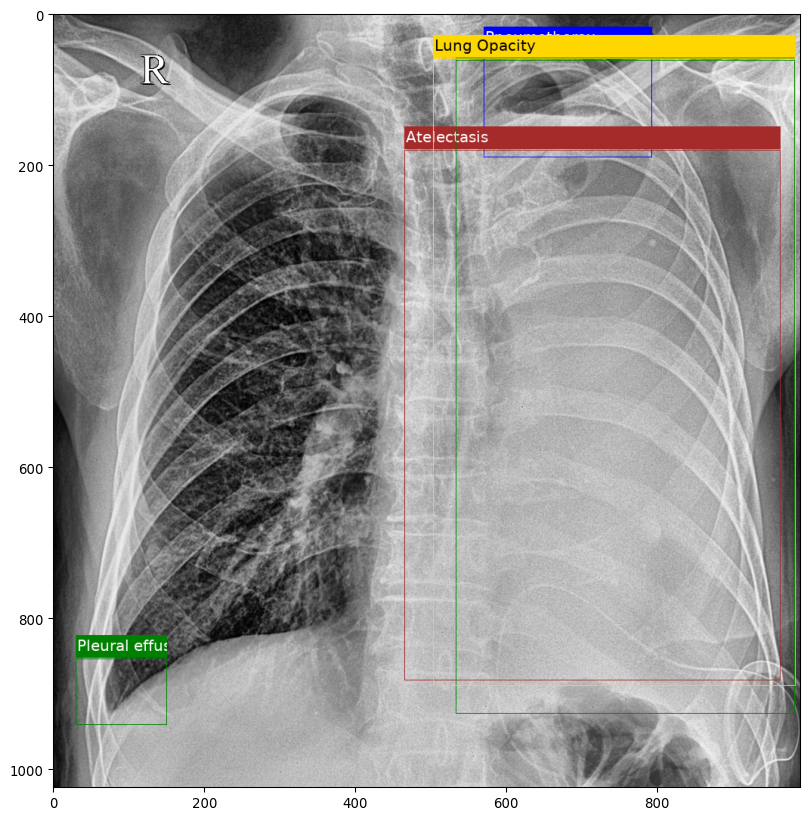

In [7]:
# Show example image

image_id = '051132a778e61a86eb147c7c6f564dfe'
image_id ='76339ec8c17dbcdd117914581cee59f5'

show_dicom(fpath=dicom_path, image_id=image_id,df=df)

In [8]:
# Define 'dic' as Dicom_image and read dicom file
classes = get_classes(df)

dic = Dicom_image(path=dicom_path, image_name=image_id, classes=classes)


In [9]:
df2 = df[df['image_id']==image_id]
df2.head()


image_id        class_name  class_id   x_min  \
1551   76339ec8c17dbcdd117914581cee59f5  Pleural effusion        10  1133.0   
4596   76339ec8c17dbcdd117914581cee59f5      Pneumothorax        12  1284.0   
41346  76339ec8c17dbcdd117914581cee59f5       Atelectasis         1  1049.0   
52872  76339ec8c17dbcdd117914581cee59f5  Pleural effusion        10  1201.0   
53315  76339ec8c17dbcdd117914581cee59f5      Lung Opacity         7  1133.0   

       y_min   x_max   y_max  
1551   136.0  2214.0  2003.0  
4596   110.0  1784.0   429.0  
41346  407.0  2169.0  1987.0  
52872  139.0  2211.0  2087.0  
53315  136.0  2214.0  2003.0

In [10]:
dic.add_bbox_from_df(df2)

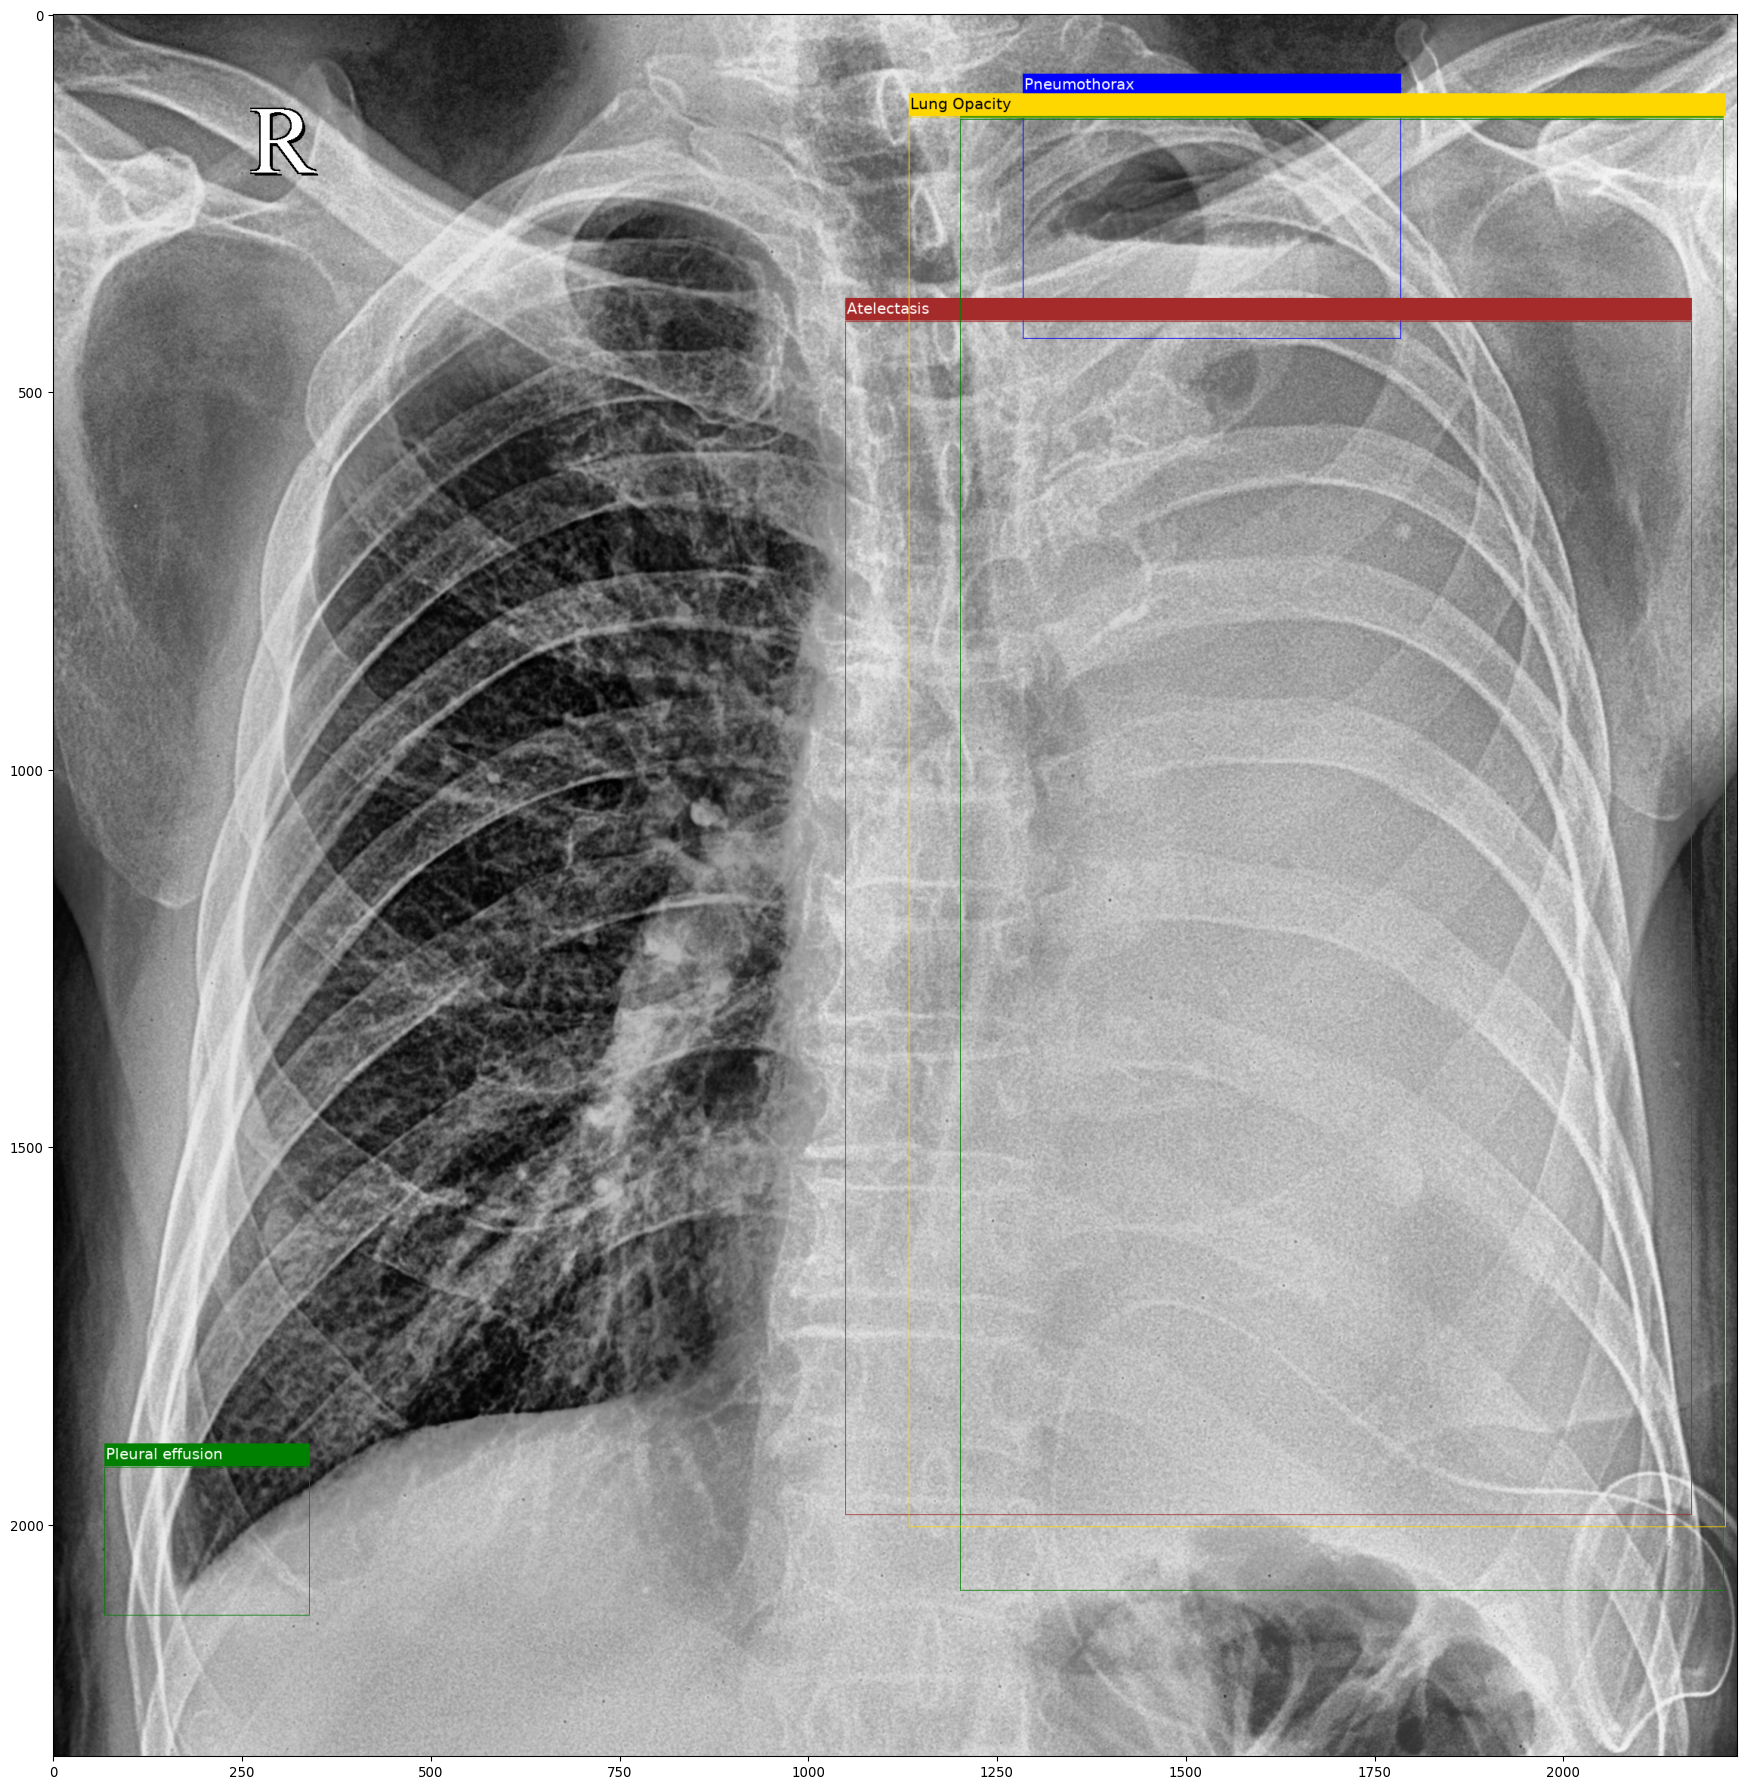

In [11]:
dic.show_image(img=None, bounding_boxes=None, showbbs=True, showlabel=True)

In [12]:
aug,bbsaug = dic.augment()

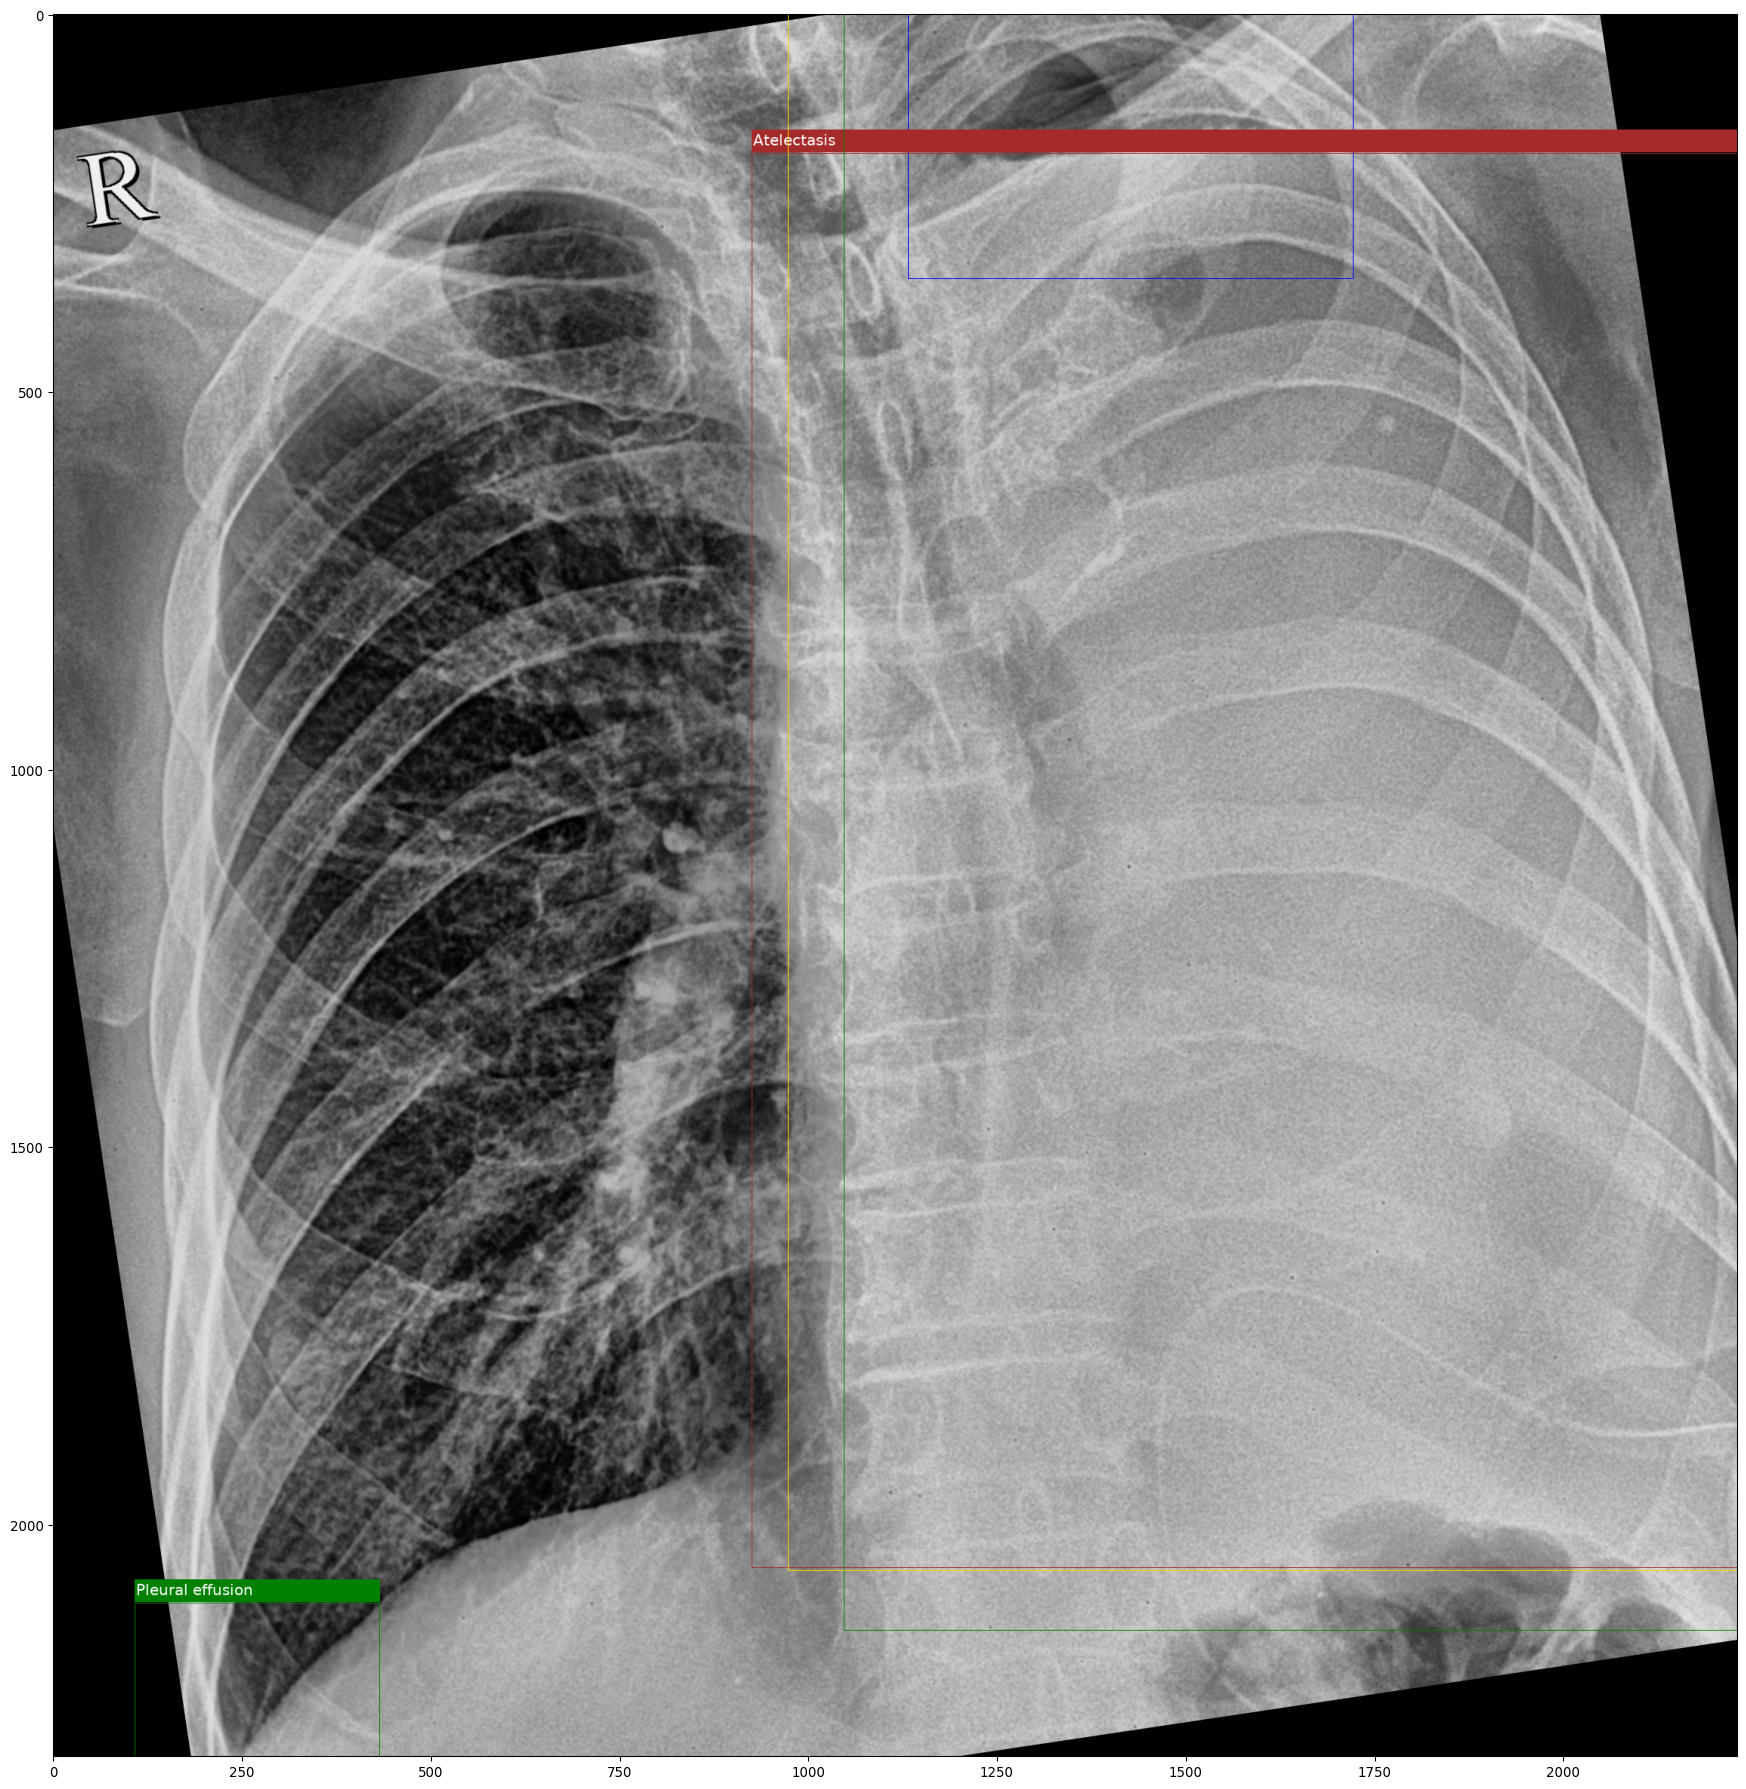

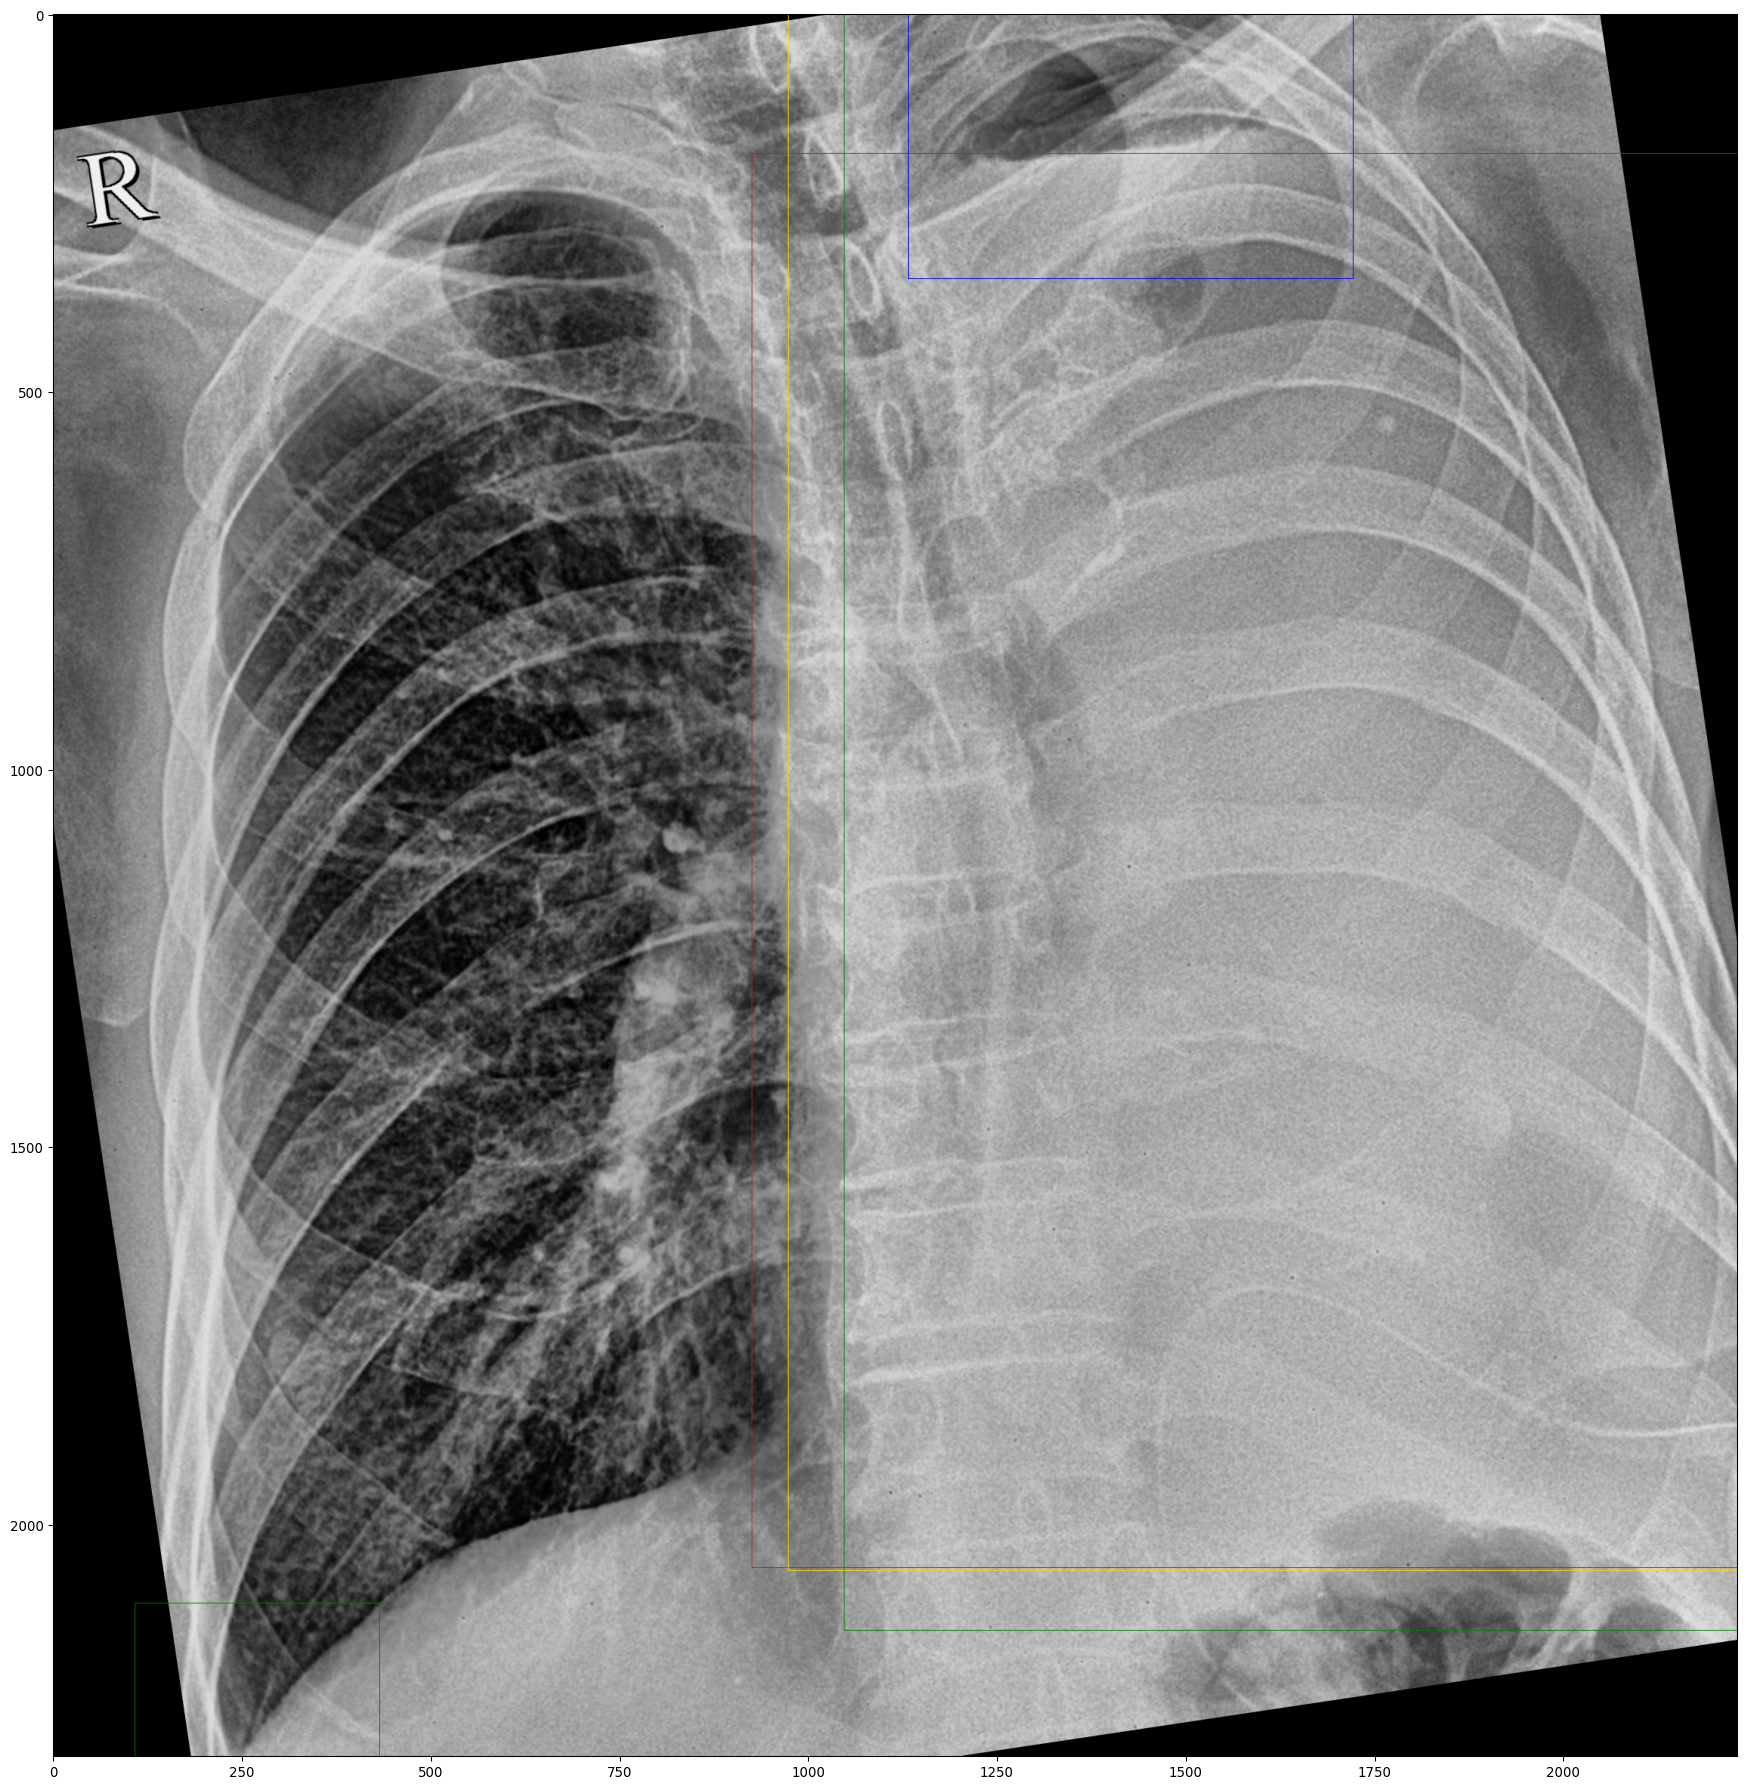

In [13]:
dic.show_image(img=dic.image_aug, bounding_boxes=dic.bbs_aug, showbbs=True, showlabel=True)
dic.show_image(img=dic.image_aug, bounding_boxes=dic.bbs_aug, showbbs=True, showlabel=False)

In [14]:
bbsaug

BoundingBoxesOnImage([BoundingBox(x1=973.0644, y1=-113.6902, x2=2434.2876, y2=2060.7190, label=10), BoundingBox(x1=1131.7120, y1=-72.1890, x2=1721.2532, y2=350.1897, label=12), BoundingBox(x1=925.4775, y1=183.8812, x2=2383.2439, y2=2057.1270, label=1), BoundingBox(x1=1046.8400, y1=-109.9926, x2=2444.3701, y2=2139.7378, label=10), BoundingBox(x1=973.0644, y1=-113.6902, x2=2434.2876, y2=2060.7190, label=7), BoundingBox(x1=108.4986, y1=2104.1521, x2=431.6922, y2=2357.8301, label=10)], shape=(2307, 2231, 3))

In [15]:
bbsaug.clip_out_of_image()

BoundingBoxesOnImage([BoundingBox(x1=973.0644, y1=0.0000, x2=2231.0000, y2=2060.7190, label=10), BoundingBox(x1=1131.7120, y1=0.0000, x2=1721.2532, y2=350.1897, label=12), BoundingBox(x1=925.4775, y1=183.8812, x2=2231.0000, y2=2057.1270, label=1), BoundingBox(x1=1046.8400, y1=0.0000, x2=2231.0000, y2=2139.7378, label=10), BoundingBox(x1=973.0644, y1=0.0000, x2=2231.0000, y2=2060.7190, label=7), BoundingBox(x1=108.4986, y1=2104.1521, x2=431.6922, y2=2307.0000, label=10)], shape=(2307, 2231, 3))

In [16]:
bbsaug[0].height

2174.4092

In [17]:
bbsaug.clip_out_of_image()[0].height

2060.718994140625